# モデルの精度を保証する実装  

本章では、機械学習モデルの構築のテクニックとして、Cross Validatioｎ（交差検証）と LightGBM の本格的な実装について触れます。LightGBM はテーブルデータを主に扱う際の手法として、予測精度では高い精度が出やすいと言われており、多くのコンペティションなどでも採用されるアルゴリズムです。  

本章では、その精度を向上させるためのテクニックと、精度を保証するために必要な Cross Validatioｎ の実装方法について触れます。  

**本章の目的**  

* Cross Validation の実装方法を理解する  
* LightGBM の実践的な実装方法を理解する  

**本章で使用するデータセット**   

* [Adult Gensus Income](data/adult2.csv)

## Cross Validation とは



Cross Validation とは学習用のデータセットを複数に分割してそれぞれの分割で学習・検証のデータセットを作り、モデルの性能を見積もる枠組みのことです。

一番有名なものは KFold と呼ばれるものです。これはランダムに学習データを分割します。
その他にターゲットの分布が同じになるように分割する Stratified と呼ばれる方法もあります。

あとは「各分割で特定のグループが重ならないようにする」Group K Fold もよく使われます。

その他にも時系列で区切る time split という方法もあります。どれを使えばよいかは test データがどのように構成されているか依存なので、データを見て決定します。

## LightGBM による CrossValidation を用いた学習



今回は使う機械学習モデルとして lightGBM を使います。lightGBM は以下のような良い性質があります。

* 欠損値が存在している場合にも、欠損を埋めることなく自然に取り扱うことができる
* 特徴重要度をさっと出すことができる
* GBDT と呼ばれるアルゴリズムの一種で今回のタスクのようなテーブルデータで性能が高いことが知られている
* CPU 環境でも高速に学習・推論が行える

他にも理由はありますが以下のような記事も参考になります。    

▼ [「初手LightGBM」をする7つの理由](https://upura.hatenablog.com/entry/2019/10/29/184617)

In [2]:
!pip install -q lightgbm

In [6]:
import lightgbm as lgbm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [57]:
def fit_lgbm(X, t, cv, params: dict=None, verbose: int=50):

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros_like(t, dtype=np.float)

    # この部分が交差検証のところです。データセットを cv instance によって分割します
    # training data を trian/val に分割
    for i, (idx_train, idx_val) in enumerate(cv): 
        x_train, t_train = X.values[idx_train], t.values[idx_train]
        x_val, t_val = X.values[idx_val], t.values[idx_val]

        clf = lgbm.LGBMClassifier(**params)

        clf.fit(x_train, t_train, eval_set=[(x_val, t_val)], early_stopping_rounds=100, verbose=verbose)

        pred_i = clf.predict(x_val)
        oof_pred[idx_val] = pred_i
        models.append(clf)
        print(f'Fold {i}')
        print(f'Accuracy: {accuracy_score(t_val, pred_i) ** .5:.4f}')
        print(f'Precision: {precision_score(t_val, pred_i) ** .5:.4f}')
        print(f'Recall: {recall_score(t_val, pred_i) ** .5:.4f}')
        print(f'F1 Score: {f1_score(t_val, pred_i) ** .5:.4f}')

    score = f1_score(t, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole F1 Score: {:.4f}'.format(score))
    return oof_pred, models

### parameter について

LightGBM などの GBDT のパラメータは、内部的にどういう意味を持つのかを知っておくことで、課題設定ごとにどのようにパラメータを調整スべきかを感覚的に掴むことができます。  

* [Parameters Tuning](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)
* [勾配ブースティングで大事なパラメータの気持ち](https://nykergoto.hatenablog.jp/entry/2019/03/29/%E5%8B%BE%E9%85%8D%E3%83%96%E3%83%BC%E3%82%B9%E3%83%86%E3%82%A3%E3%83%B3%E3%82%B0%E3%81%A7%E5%A4%A7%E4%BA%8B%E3%81%AA%E3%83%91%E3%83%A9%E3%83%A1%E3%83%BC%E3%82%BF%E3%81%AE%E6%B0%97%E6%8C%81%E3%81%A1)

In [58]:
params = {
    # 目的関数. 最小となるようなパラメータを探します. 
    'objective': 'binary', 

     # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、がそれだけ木を作るため学習に時間がかかります
    'learning_rate': .1,

    # L2 Reguralization
    'reg_lambda': 1.,
    # L1 
    'reg_alpha': .1,

    # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    'max_depth': 5, 

    # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    'n_estimators': 10000, 

    # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    'colsample_bytree': .5, 

    # 最小分割でのデータ数. 小さいとより細かい粒度の分割方法を許容します.
    'min_child_samples': 10,

    # bagging の頻度と割合
    'subsample_freq': 3,
    'subsample': .9,

    # 特徴重要度計算のロジック
    'importance_type': 'gain', 
    'random_state': 0,
}

## データの準備  

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
df = pd.read_csv('adult2.csv')
df.head(2)

,age,education.num,capital.gain,capital.loss,hours.per.week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,workclass_Self-emp-inc,...,race_Black,race_Other,race_White,sex_Female,sex_Male,marital-group_Married,marital-group_NotMarried,marital-group_Separated,marital-group_Widowed,target
0,90,9,0,4356,40,0,0,0,0,0,...,0,0,1,1,0,0,0,0,1,<=50K
1,82,9,0,4356,18,0,0,0,1,0,...,0,0,1,1,0,0,0,0,1,<=50K


In [61]:
target_dict = {'<=50K':0, '>50K':1}
x = df.drop('target', axis=1)
t = df['target'].map(target_dict)

In [62]:
from sklearn.model_selection import KFold

fold = KFold(n_splits=5, shuffle=True, random_state=0)
cv = list(fold.split(x, t))

oof, models = fit_lgbm(x, t, cv, params=params, verbose=500)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[323]	valid_0's binary_logloss: 0.273191
Fold 0
Accuracy: 0.9359
Precision: 0.8786
Recall: 0.8193
F1 Score: 0.8474
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[263]	valid_0's binary_logloss: 0.26657
Fold 1
Accuracy: 0.9346
Precision: 0.8804
Recall: 0.8184
F1 Score: 0.8477
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[312]	valid_0's binary_logloss: 0.276577
Fold 2
Accuracy: 0.9338
Precision: 0.8854
Recall: 0.8070
F1 Score: 0.8435
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[289]	valid_0's binary_logloss: 0.269246
Fold 3
Accuracy: 0.9343
Precision: 0.8846
Recall: 0.8081
F1 Score: 0.8438
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[178]	valid_0's binary_logloss: 0.285566
Fold 4
Acc

## 特徴量重要度 (FeatureImporatnce) の可視化



LightGBM など木系のモデルではどの特徴量で分割を行ってどれだけ目的変数を説明しているかを特徴重要度 (feature importance) として出力することができます。これを見ることで

* どの特徴量が大事なのか
* どの特徴量はあまり大事ではないか

といった特徴量に関する情報を得ることができます。これによって、例えば重要となった特徴量を使う別の特徴を考えたり、反対に大事ではない特徴を削ったりといったインサイトを得ることが可能です。

In [36]:
def visualize_importance(models, df_train_feature):
    
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = df_train_feature.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    return fig, ax, feature_importance_df

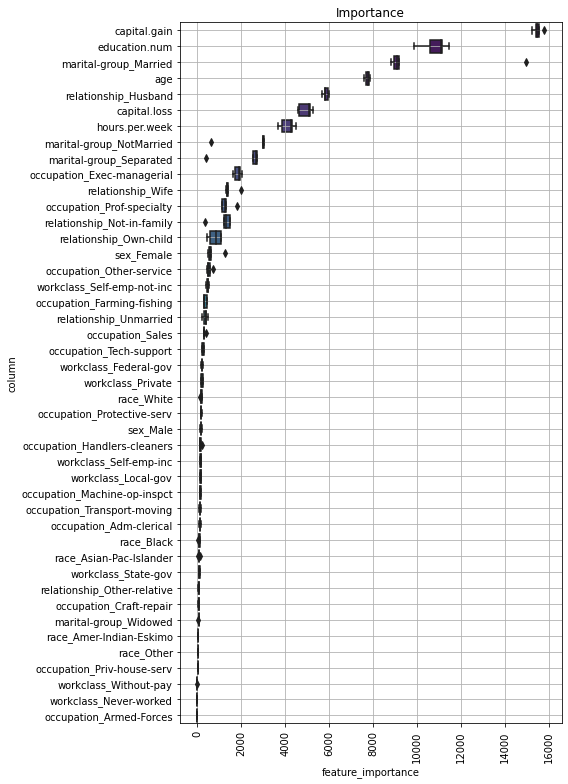

In [37]:
fig, ax, feature_importance_df = visualize_importance(models, df.drop('target', axis=1))

In [43]:
feature_importance_df.groupby('column').sum().sort_values('feature_importance', ascending=False).head(10)

,feature_importance,fold
column,,
capital.gain,77382.412387,15
education.num,54119.537804,15
marital-group_Married,50938.390608,15
age,38741.040416,15
relationship_Husband,29218.304230,15
capital.loss,24718.682911,15
hours.per.week,20558.669582,15
marital-group_NotMarried,12624.540526,15
marital-group_Separated,11077.268367,15


## 学習済みモデルを用いた予測結果の確認

In [45]:
pred = np.array([model.predict(x) for model in models])
pred = np.mean(pred, axis=0)

## 予測値の分布を確認

あまりに大きくずれているときは実装がおかしい or 分布がずれている可能性が高いです。

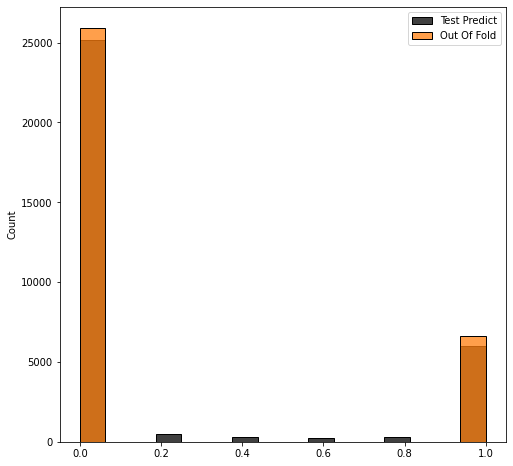

In [46]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(pred, label='Test Predict', ax=ax, color='black')
sns.histplot(oof, label='Out Of Fold', ax=ax, color='C1')
ax.legend();

## 【補足】 Permutation Feature Importance

In [47]:
from sklearn.inspection import permutation_importance

In [89]:
def fit_lgbm(X, t, cv, params: dict=None, verbose: int=50):

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    importance_list = []
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros_like(t, dtype=np.float)

    # この部分が交差検証のところです。データセットを cv instance によって分割します
    # training data を trian/val に分割
    for i, (idx_train, idx_val) in enumerate(cv): 
        x_train, t_train = X.values[idx_train], t.values[idx_train]
        x_val, t_val = X.values[idx_val], t.values[idx_val]

        clf = lgbm.LGBMClassifier(**params)

        clf.fit(x_train, t_train, eval_set=[(x_val, t_val)], early_stopping_rounds=100, verbose=verbose)

        # PI の実装を追加
        result = permutation_importance(clf, x_val, t_val, n_repeats=10, random_state=0)

        importance_list.append(result.importances_mean)
        pred_i = clf.predict(x_val)
        oof_pred[idx_val] = pred_i
        models.append(clf)
        print(f'Fold {i}')
        print(f'Accuracy: {accuracy_score(t_val, pred_i) ** .5:.4f}')
        print(f'Precision: {precision_score(t_val, pred_i) ** .5:.4f}')
        print(f'Recall: {recall_score(t_val, pred_i) ** .5:.4f}')
        print(f'F1 Score: {f1_score(t_val, pred_i) ** .5:.4f}')

    score = f1_score(t, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole F1 Score: {:.4f}'.format(score))
    return oof_pred, models, importance_list

In [90]:
from sklearn.model_selection import KFold

fold = KFold(n_splits=5, shuffle=True, random_state=0)
cv = list(fold.split(x, t))

oof, models, importance_list = fit_lgbm(x, t, cv, params=params, verbose=500)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[323]	valid_0's binary_logloss: 0.273191
Fold 0
Accuracy: 0.9359
Precision: 0.8786
Recall: 0.8193
F1 Score: 0.8474
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[263]	valid_0's binary_logloss: 0.26657
Fold 1
Accuracy: 0.9346
Precision: 0.8804
Recall: 0.8184
F1 Score: 0.8477
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[312]	valid_0's binary_logloss: 0.276577
Fold 2
Accuracy: 0.9338
Precision: 0.8854
Recall: 0.8070
F1 Score: 0.8435
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[289]	valid_0's binary_logloss: 0.269246
Fold 3
Accuracy: 0.9343
Precision: 0.8846
Recall: 0.8081
F1 Score: 0.8438
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[178]	valid_0's binary_logloss: 0.285566
Fold 4
Acc

In [95]:
def visualize_importance(models, feature_list, df):
    
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = importance_list[i]
        _df['column'] = df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df],
                                            axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    return fig, ax, feature_importance_df

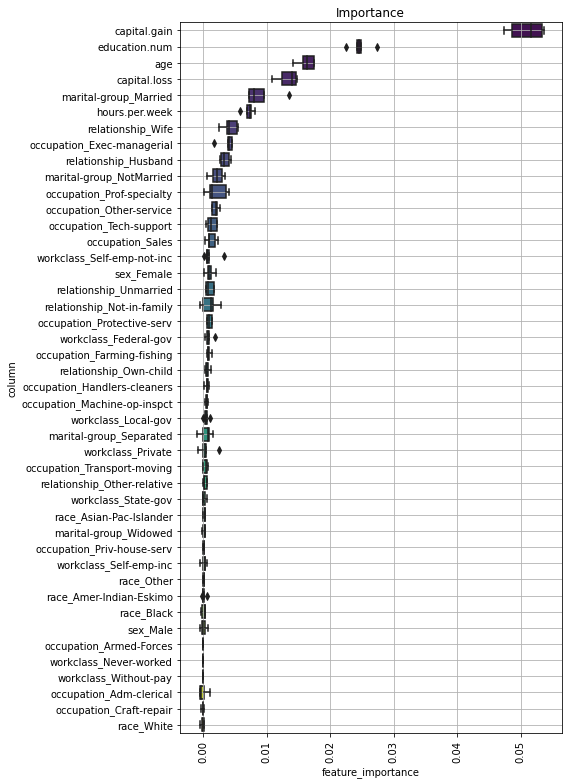

In [96]:
fig, ax, feature_importance_df = visualize_importance(models, importance_list, df.drop('target', axis=1))